In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
import sys, gc, warnings, random, math, time, datetime 
from tqdm import tqdm

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

import os
print(os.listdir("../input"))

['train_transaction.csv', 'train_identity.csv', 'ieee-fe-with-some-eda', 'sample_submission.csv', 'ieee-data-minification', 'reduced', 'standalone-train-and-test-preprocessing', 'test_identity.csv', 'test_transaction.csv', 'ieee-fe-for-local-test']


In [2]:
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')

In [3]:
print(train_transaction.shape)
print(test_transaction.shape)

(590540, 393)
(506691, 392)


In [4]:
def text_distribution(col):
    for item in train_transaction_transformed[col].unique():
        print(item, train_transaction_transformed[train_transaction_transformed[col] == item]['isFraud'].sum() / train_transaction_transformed[train_transaction_transformed[col] == item].shape[0])

In [5]:
def see_distribution(col,bin_size):
    train_transaction[col].hist(bins=bin_size, alpha = 0.5)
    test_transaction[col].hist(bins=bin_size, alpha = 0.5)
    train_transaction[train_transaction['isFraud']==1][col].hist(bins=bin_size)
    plt.show()

In [6]:
def plot_trend(col):
    plt.plot(train_transaction[col],'.b', markersize=5)
    plt.plot(test_transaction[col],'.r', markersize=5)
    plt.grid()
    plt.show()

In [7]:
train_transaction.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.

In [8]:
cols = test_transaction.columns
combined_transaction = pd.concat([train_transaction[cols], test_transaction[cols]],axis=0)
combined_transaction.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN

In [9]:
# map
CD_map = combined_transaction['ProductCD'].value_counts().to_dict()   
card4_map = combined_transaction['card4'].value_counts().to_dict()   
card6_map = combined_transaction['card6'].value_counts().to_dict() 
m4_map = combined_transaction['M4'].value_counts().to_dict() 

P_domain_map = combined_transaction['P_emaildomain'].value_counts().to_dict()
for key, value in P_domain_map.items():
    P_domain_map[key] = int(P_domain_map[key] > 2000)

R_domain_map = combined_transaction['R_emaildomain'].value_counts().to_dict()
for key, value in R_domain_map.items():
    R_domain_map[key] = int(R_domain_map[key] > 2000)
    
T_F_map = {'T':1, 'F':0}

In [10]:
def fe(transaction):
    
#     transaction_transformed['day'] = transaction_transformed['TransactionDT'] // 86400

    # create date column
    START_DATE = '2017-12-01'
    startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
#     transaction['date'] = transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
   
    
    # hour in the day
#     transaction['hour'] = transaction['TransactionDT'] % 86400 // 3600
    
    # transaction amount
    transaction['TransactionAmt'] = transaction['TransactionAmt'].apply(lambda y: y if y <= 10000 else 10000)
    
    # productCD
    # 5 mini-model
    transaction['ProductCD'] = transaction['ProductCD'].map(CD_map)
    
    # card 1-6, card info
    transaction['card4'] = transaction['card4'].map(card4_map)
    transaction['card6'] = transaction['card6'].map(card6_map)
    
    # address, region and county
    
    # dist 1, 2
    transaction['dist1'] = transaction['dist1'].apply(lambda y: y if y <= 3000 else 3000)
    transaction['dist2'] = transaction['dist2'].apply(lambda y: y if y <= 3000 else 3000)
    
    # email domains
    transaction['P_emaildomain'] = transaction['P_emaildomain'].map(P_domain_map)
    transaction['R_emaildomain'] = transaction['R_emaildomain'].map(R_domain_map)
    
    # C1-C14
    transaction['C1'] = transaction['C1'].apply(lambda y: y if y <= 500 else 500)
    transaction['C2'] = transaction['C2'].apply(lambda y: y if y <= 500 else 500)
    transaction['C3'] = transaction['C3'].apply(lambda y: y if y <= 3 else 3)
    transaction['C4'] = transaction['C4'].apply(lambda y: y if y <= 300 else 300)
    transaction['C5'] = transaction['C5'].apply(lambda y: y if y <= 300 else 300)
    transaction['C6'] = transaction['C6'].apply(lambda y: y if y <= 300 else 300)
    transaction['C7'] = transaction['C7'].apply(lambda y: y if y <= 300 else 300)
    transaction['C8'] = transaction['C8'].apply(lambda y: y if y <= 300 else 300)
    transaction['C9'] = transaction['C9'].apply(lambda y: y if y <= 300 else 300)
    transaction['C10'] = transaction['C10'].apply(lambda y: y if y <= 300 else 300)
    transaction['C11'] = transaction['C11'].apply(lambda y: y if y <= 300 else 300)
    transaction['C12'] = transaction['C12'].apply(lambda y: y if y <= 300 else 300)
    transaction['C13'] = transaction['C13'].apply(lambda y: y if y <= 1000 else 1000)
    transaction['C14'] = transaction['C14'].apply(lambda y: y if y <= 300 else 300)
    
    # D1-D15
    transaction['D1'] = transaction['D1'].apply(lambda y: y if y <= 480 else 480)
    transaction['D2'] = transaction['D2'].apply(lambda y: y if y <= 480 else 480)
    transaction['D3'] = transaction['D3'].apply(lambda y: y if y <= 480 else 480)
    transaction['D4'] = transaction['D4'].apply(lambda y: y if y <= 480 else 480)
    transaction['D5'] = transaction['D5'].apply(lambda y: y if y <= 700 else 700)
    transaction['D6'] = transaction['D6'].apply(lambda y: y if y <= 480 else 480)
    transaction['D7'] = transaction['D7'].apply(lambda y: y if y <= 480 else 480)
    transaction['D8'] = transaction['D8'].apply(lambda y: y if y <= 800 else 800)
    transaction['D9'] = transaction['D9'].apply(lambda y: y if y <= 480 else 480)
    transaction['D10'] = transaction['D10'].apply(lambda y: y if y <= 480 else 480)
    transaction['D11'] = transaction['D11'].apply(lambda y: y if y <= 480 else 480)
    transaction['D12'] = transaction['D12'].apply(lambda y: y if y <= 480 else 480)
    transaction['D13'] = transaction['D13'].apply(lambda y: y if y <= 480 else 480)
    transaction['D14'] = transaction['D14'].apply(lambda y: y if y <= 480 else 480)
    transaction['D15'] = transaction['D15'].apply(lambda y: y if y <= 480 else 480)
    
    # M1-M9
    for col in ['M1','M2','M3','M5','M6','M7','M8','M9']:
        transaction[col] = transaction[col].map(T_F_map)
    transaction['M4'] = transaction['M4'].map(m4_map)

    # V1-V340
    transaction['V2'] = transaction['V2'].apply(lambda y: y if y <= 6 else 6)
    transaction['V3'] = transaction['V3'].apply(lambda y: y if y <= 8 else 8)
    transaction['V4'] = transaction['V4'].apply(lambda y: y if y <= 5 else 5)
    transaction['V5'] = transaction['V5'].apply(lambda y: y if y <= 5 else 5)
    transaction['V6'] = transaction['V6'].apply(lambda y: y if y <= 6 else 6)
    transaction['V7'] = transaction['V7'].apply(lambda y: y if y <= 7 else 7)
    transaction['V8'] = transaction['V8'].apply(lambda y: y if y <= 6 else 6)
    transaction['V9'] = transaction['V9'].apply(lambda y: y if y <= 6 else 6)
    transaction['V10'] = transaction['V10'].apply(lambda y: y if y <= 3 else 3)
    transaction['V11'] = transaction['V11'].apply(lambda y: y if y <= 4 else 4)
    transaction['V12'] = transaction['V12'].apply(lambda y: y if y <= 3 else 3)
    transaction['V13'] = transaction['V13'].apply(lambda y: y if y <= 5 else 5)
    transaction['V15'] = transaction['V15'].apply(lambda y: y if y <= 3 else 3)
    transaction['V16'] = transaction['V16'].apply(lambda y: y if y <= 5 else 5)
    transaction['V17'] = transaction['V17'].apply(lambda y: y if y <= 6 else 6)
    transaction['V18'] = transaction['V18'].apply(lambda y: y if y <= 6 else 6)
    transaction['V19'] = transaction['V19'].apply(lambda y: y if y <= 4 else 4)
    transaction['V20'] = transaction['V20'].apply(lambda y: y if y <= 6 else 6)
    transaction['V21'] = transaction['V21'].apply(lambda y: y if y <= 3 else 3)
    transaction['V22'] = transaction['V22'].apply(lambda y: y if y <= 7 else 7)
    transaction['V23'] = transaction['V23'].apply(lambda y: y if y <= 10 else 10)
    transaction['V24'] = transaction['V24'].apply(lambda y: y if y <= 10 else 10)
    transaction['V25'] = transaction['V25'].apply(lambda y: y if y <= 3 else 3)
    transaction['V26'] = transaction['V26'].apply(lambda y: y if y <= 4 else 4)
    transaction['V27'] = transaction['V27'].apply(lambda y: y if y <= 1 else 1)
    transaction['V28'] = transaction['V28'].apply(lambda y: y if y <= 1 else 1)
    transaction['V29'] = transaction['V29'].apply(lambda y: y if y <= 4 else 4)
    transaction['V30'] = transaction['V30'].apply(lambda y: y if y <= 5 else 5)
    transaction['V31'] = transaction['V31'].apply(lambda y: y if y <= 3 else 3)
    transaction['V32'] = transaction['V32'].apply(lambda y: y if y <= 4 else 4)
    transaction['V33'] = transaction['V33'].apply(lambda y: y if y <= 3 else 3)
    transaction['V34'] = transaction['V34'].apply(lambda y: y if y <= 3 else 3)
    transaction['V35'] = transaction['V35'].apply(lambda y: y if y <= 3 else 3)
    transaction['V36'] = transaction['V36'].apply(lambda y: y if y <= 3 else 3)
    transaction['V37'] = transaction['V37'].apply(lambda y: y if y <= 10 else 10)
    transaction['V38'] = transaction['V38'].apply(lambda y: y if y <= 10 else 10)
    transaction['V39'] = transaction['V39'].apply(lambda y: y if y <= 6 else 6)
    transaction['V40'] = transaction['V40'].apply(lambda y: y if y <= 8 else 8)
    transaction['V42'] = transaction['V42'].apply(lambda y: y if y <= 3 else 3)
    transaction['V43'] = transaction['V43'].apply(lambda y: y if y <= 4 else 4)
    transaction['V44'] = transaction['V44'].apply(lambda y: y if y <= 5 else 5)
    transaction['V45'] = transaction['V45'].apply(lambda y: y if y <= 5 else 5)
    transaction['V46'] = transaction['V46'].apply(lambda y: y if y <= 3 else 3)
    transaction['V47'] = transaction['V47'].apply(lambda y: y if y <= 4 else 4)
    transaction['V48'] = transaction['V48'].apply(lambda y: y if y <= 3 else 3)
    transaction['V49'] = transaction['V49'].apply(lambda y: y if y <= 4 else 4)
    transaction['V50'] = transaction['V50'].apply(lambda y: y if y <= 2 else 2)
    transaction['V51'] = transaction['V51'].apply(lambda y: y if y <= 3 else 3)
    transaction['V52'] = transaction['V52'].apply(lambda y: y if y <= 4 else 4)
    transaction['V53'] = transaction['V53'].apply(lambda y: y if y <= 3 else 3)
    transaction['V54'] = transaction['V54'].apply(lambda y: y if y <= 3 else 3)
    transaction['V55'] = transaction['V55'].apply(lambda y: y if y <= 6 else 6)
    transaction['V56'] = transaction['V56'].apply(lambda y: y if y <= 6 else 6)
    transaction['V57'] = transaction['V57'].apply(lambda y: y if y <= 2 else 2)
    transaction['V58'] = transaction['V58'].apply(lambda y: y if y <= 3 else 3)
    transaction['V59'] = transaction['V59'].apply(lambda y: y if y <= 4 else 4)
    transaction['V60'] = transaction['V60'].apply(lambda y: y if y <= 4 else 4)
    transaction['V61'] = transaction['V61'].apply(lambda y: y if y <= 3 else 3)
    transaction['V62'] = transaction['V62'].apply(lambda y: y if y <= 4 else 4)
    transaction['V63'] = transaction['V63'].apply(lambda y: y if y <= 3 else 3)
    transaction['V64'] = transaction['V64'].apply(lambda y: y if y <= 5 else 5)
    transaction['V66'] = transaction['V66'].apply(lambda y: y if y <= 3 else 3)
    transaction['V67'] = transaction['V67'].apply(lambda y: y if y <= 3 else 3)
    transaction['V68'] = transaction['V68'].apply(lambda y: y if y <= 1 else 1)
    transaction['V69'] = transaction['V69'].apply(lambda y: y if y <= 3 else 3)
    transaction['V70'] = transaction['V70'].apply(lambda y: y if y <= 4 else 4)
    transaction['V71'] = transaction['V71'].apply(lambda y: y if y <= 3 else 3)
    transaction['V72'] = transaction['V72'].apply(lambda y: y if y <= 3 else 3)
    transaction['V73'] = transaction['V73'].apply(lambda y: y if y <= 3 else 3)
    transaction['V74'] = transaction['V74'].apply(lambda y: y if y <= 3 else 3)
    transaction['V75'] = transaction['V75'].apply(lambda y: y if y <= 3 else 3)
    transaction['V76'] = transaction['V76'].apply(lambda y: y if y <= 3 else 3)
    transaction['V77'] = transaction['V77'].apply(lambda y: y if y <= 6 else 6)
    transaction['V78'] = transaction['V78'].apply(lambda y: y if y <= 6 else 6)
    transaction['V79'] = transaction['V79'].apply(lambda y: y if y <= 3 else 3)
    transaction['V80'] = transaction['V80'].apply(lambda y: y if y <= 5 else 5)
    transaction['V81'] = transaction['V81'].apply(lambda y: y if y <= 5 else 5)
    transaction['V82'] = transaction['V82'].apply(lambda y: y if y <= 3 else 3)
    transaction['V83'] = transaction['V83'].apply(lambda y: y if y <= 4 else 4)
    transaction['V84'] = transaction['V84'].apply(lambda y: y if y <= 3 else 3)
    transaction['V85'] = transaction['V85'].apply(lambda y: y if y <= 4 else 4)
    transaction['V86'] = transaction['V86'].apply(lambda y: y if y <= 6 else 6)
    transaction['V87'] = transaction['V87'].apply(lambda y: y if y <= 6 else 6)
    transaction['V89'] = transaction['V89'].apply(lambda y: y if y <= 1 else 1)
    transaction['V90'] = transaction['V90'].apply(lambda y: y if y <= 3 else 3)
    transaction['V91'] = transaction['V91'].apply(lambda y: y if y <= 4 else 4)
    transaction['V92'] = transaction['V92'].apply(lambda y: y if y <= 3 else 3)
    transaction['V93'] = transaction['V93'].apply(lambda y: y if y <= 3 else 3)
    transaction['V94'] = transaction['V94'].apply(lambda y: y if y <= 1 else 1)
    transaction['V95'] = transaction['V95'].apply(lambda y: y if y <= 30 else 30) #
    transaction['V96'] = transaction['V96'].apply(lambda y: y if y <= 50 else 50) #
    transaction['V97'] = transaction['V97'].apply(lambda y: y if y <= 50 else 50) #
    transaction['V98'] = transaction['V98'].apply(lambda y: y if y <= 4 else 4)
    transaction['V99'] = transaction['V99'].apply(lambda y: y if y <= 10 else 10)
    transaction['V100'] = transaction['V100'].apply(lambda y: y if y <= 6 else 6)
    transaction['V101'] = transaction['V101'].apply(lambda y: y if y <= 20 else 20) #
    transaction['V102'] = transaction['V102'].apply(lambda y: y if y <= 50 else 50) #
    transaction['V103'] = transaction['V103'].apply(lambda y: y if y <= 30 else 30) #
    transaction['V104'] = transaction['V104'].apply(lambda y: y if y <= 5 else 5)
    transaction['V105'] = transaction['V105'].apply(lambda y: y if y <= 10 else 10) #
    transaction['V106'] = transaction['V106'].apply(lambda y: y if y <= 5 else 5) # 
    transaction['V108'] = transaction['V108'].apply(lambda y: y if y <= 3 else 3) 
    transaction['V109'] = transaction['V109'].apply(lambda y: y if y <= 3 else 3) 
    transaction['V110'] = transaction['V110'].apply(lambda y: y if y <= 3 else 3) 
    transaction['V111'] = transaction['V111'].apply(lambda y: y if y <= 3 else 3) 
    transaction['V112'] = transaction['V112'].apply(lambda y: y if y <= 3 else 3) 
    transaction['V113'] = transaction['V113'].apply(lambda y: y if y <= 3 else 3) 
    transaction['V114'] = transaction['V114'].apply(lambda y: y if y <= 3 else 3) 
    transaction['V115'] = transaction['V115'].apply(lambda y: y if y <= 4 else 4) 
    transaction['V116'] = transaction['V116'].apply(lambda y: y if y <= 3 else 3) 
    transaction['V117'] = transaction['V117'].apply(lambda y: y if y <= 2 else 2) #0
    transaction['V118'] = transaction['V118'].apply(lambda y: y if y <= 2 else 2) #0
    transaction['V119'] = transaction['V119'].apply(lambda y: y if y <= 2 else 2) #0
    transaction['V120'] = transaction['V120'].apply(lambda y: y if y <= 2 else 2) #0
    transaction['V121'] = transaction['V121'].apply(lambda y: y if y <= 2 else 2) #0
    transaction['V122'] = transaction['V122'].apply(lambda y: y if y <= 2 else 2) #0
    transaction['V123'] = transaction['V123'].apply(lambda y: y if y <= 6 else 6) 
    transaction['V124'] = transaction['V124'].apply(lambda y: y if y <= 6 else 6) 
    transaction['V125'] = transaction['V125'].apply(lambda y: y if y <= 6 else 6) 
    transaction['V126'] = transaction['V126'].apply(lambda y: y if y <= 5000 else 5000) #
    transaction['V127'] = transaction['V127'].apply(lambda y: y if y <= 5000 else 5000) #
    transaction['V128'] = transaction['V128'].apply(lambda y: y if y <= 5000 else 5000) #
    transaction['V129'] = transaction['V129'].apply(lambda y: y if y <= 1000 else 1000) #
    transaction['V130'] = transaction['V130'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V131'] = transaction['V131'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V132'] = transaction['V132'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V133'] = transaction['V133'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V134'] = transaction['V134'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V135'] = transaction['V135'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V136'] = transaction['V136'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V137'] = transaction['V137'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V138'] = transaction['V138'].apply(lambda y: y if y <= 5 else 5)
    transaction['V139'] = transaction['V139'].apply(lambda y: y if y <= 10 else 10)
    transaction['V140'] = transaction['V140'].apply(lambda y: y if y <= 10 else 10)
    transaction['V141'] = transaction['V141'].apply(lambda y: y if y <= 2 else 2)
    transaction['V142'] = transaction['V142'].apply(lambda y: y if y <= 4 else 4)
    transaction['V143'] = transaction['V143'].apply(lambda y: y if y <= 10 else 10) #
    transaction['V144'] = transaction['V144'].apply(lambda y: y if y <= 10 else 10) #
    transaction['V145'] = transaction['V145'].apply(lambda y: y if y <= 10 else 10) #
    transaction['V146'] = transaction['V146'].apply(lambda y: y if y <= 6 else 6)
    transaction['V147'] = transaction['V147'].apply(lambda y: y if y <= 6 else 6)
    transaction['V148'] = transaction['V148'].apply(lambda y: y if y <= 3 else 3)
    transaction['V149'] = transaction['V149'].apply(lambda y: y if y <= 3 else 3)
    transaction['V150'] = transaction['V150'].apply(lambda y: y if y <= 50 else 50) #
    transaction['V151'] = transaction['V151'].apply(lambda y: y if y <= 6 else 6) #
    transaction['V152'] = transaction['V152'].apply(lambda y: y if y <= 8 else 8) #?
    transaction['V153'] = transaction['V153'].apply(lambda y: y if y <= 3 else 3)
    transaction['V154'] = transaction['V154'].apply(lambda y: y if y <= 3 else 3)
    transaction['V155'] = transaction['V155'].apply(lambda y: y if y <= 3 else 3)
    transaction['V156'] = transaction['V156'].apply(lambda y: y if y <= 3 else 3)
    transaction['V157'] = transaction['V157'].apply(lambda y: y if y <= 4 else 4)
    transaction['V158'] = transaction['V158'].apply(lambda y: y if y <= 5 else 5)
    transaction['V159'] = transaction['V159'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V160'] = transaction['V160'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V161'] = transaction['V161'].apply(lambda y: y if y <= 300 else 300)
    transaction['V162'] = transaction['V162'].apply(lambda y: y if y <= 300 else 300)
    transaction['V163'] = transaction['V163'].apply(lambda y: y if y <= 300 else 300)
    transaction['V164'] = transaction['V164'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V165'] = transaction['V165'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V166'] = transaction['V166'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V167'] = transaction['V167'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V168'] = transaction['V168'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V169'] = transaction['V169'].apply(lambda y: y if y <= 10 else 10) 
    transaction['V170'] = transaction['V170'].apply(lambda y: y if y <= 12 else 12) #?
    transaction['V171'] = transaction['V171'].apply(lambda y: y if y <= 12 else 12) #?
    transaction['V172'] = transaction['V172'].apply(lambda y: y if y <= 3 else 3) 
    transaction['V173'] = transaction['V173'].apply(lambda y: y if y <= 2 else 2) 
    transaction['V174'] = transaction['V174'].apply(lambda y: y if y <= 3 else 3) 
    transaction['V175'] = transaction['V175'].apply(lambda y: y if y <= 8 else 8) 
    transaction['V176'] = transaction['V176'].apply(lambda y: y if y <= 12 else 12) #?
    transaction['V177'] = transaction['V177'].apply(lambda y: y if y <= 50 else 50) #
    transaction['V178'] = transaction['V178'].apply(lambda y: y if y <= 50 else 50) #
    transaction['V179'] = transaction['V179'].apply(lambda y: y if y <= 50 else 50) #
    transaction['V180'] = transaction['V180'].apply(lambda y: y if y <= 10 else 10) #
    transaction['V181'] = transaction['V181'].apply(lambda y: y if y <= 5 else 5) #?
    transaction['V182'] = transaction['V182'].apply(lambda y: y if y <= 10 else 10) #
    transaction['V183'] = transaction['V183'].apply(lambda y: y if y <= 10 else 10) #
    transaction['V184'] = transaction['V184'].apply(lambda y: y if y <= 6 else 6)
    transaction['V185'] = transaction['V185'].apply(lambda y: y if y <= 5 else 5) #?
    transaction['V186'] = transaction['V186'].apply(lambda y: y if y <= 6 else 6) #
    transaction['V187'] = transaction['V187'].apply(lambda y: y if y <= 25 else 25) #
    transaction['V188'] = transaction['V188'].apply(lambda y: y if y <= 5 else 5) 
    transaction['V189'] = transaction['V189'].apply(lambda y: y if y <= 5 else 5) 
    transaction['V190'] = transaction['V190'].apply(lambda y: y if y <= 10 else 10) #
    transaction['V191'] = transaction['V191'].apply(lambda y: y if y <= 5 else 5) #?
    transaction['V192'] = transaction['V192'].apply(lambda y: y if y <= 6 else 6) #
    transaction['V193'] = transaction['V193'].apply(lambda y: y if y <= 6 else 6) #
    transaction['V194'] = transaction['V194'].apply(lambda y: y if y <= 3 else 3)
    transaction['V195'] = transaction['V195'].apply(lambda y: y if y <= 3 else 3)
    transaction['V196'] = transaction['V196'].apply(lambda y: y if y <= 5 else 5) #?
    transaction['V197'] = transaction['V197'].apply(lambda y: y if y <= 3 else 3)
    transaction['V198'] = transaction['V198'].apply(lambda y: y if y <= 3 else 3)
    transaction['V199'] = transaction['V199'].apply(lambda y: y if y <= 5 else 5) #?
    transaction['V200'] = transaction['V200'].apply(lambda y: y if y <= 5 else 5)
    transaction['V201'] = transaction['V201'].apply(lambda y: y if y <= 5 else 5)
    transaction['V202'] = transaction['V202'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V203'] = transaction['V203'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V204'] = transaction['V204'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V205'] = transaction['V205'].apply(lambda y: y if y <= 500 else 500)
    transaction['V206'] = transaction['V206'].apply(lambda y: y if y <= 300 else 300)
    transaction['V207'] = transaction['V207'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V208'] = transaction['V208'].apply(lambda y: y if y <= 200 else 200)
    transaction['V209'] = transaction['V209'].apply(lambda y: y if y <= 500 else 500) #
    transaction['V210'] = transaction['V210'].apply(lambda y: y if y <= 500 else 500) #
    transaction['V211'] = transaction['V211'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V212'] = transaction['V212'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V213'] = transaction['V213'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V214'] = transaction['V214'].apply(lambda y: y if y <= 2000 else 2000)
    transaction['V215'] = transaction['V215'].apply(lambda y: y if y <= 2000 else 2000) 
    transaction['V216'] = transaction['V216'].apply(lambda y: y if y <= 2000 else 2000) 
    transaction['V217'] = transaction['V217'].apply(lambda y: y if y <= 30 else 30) #
    transaction['V218'] = transaction['V218'].apply(lambda y: y if y <= 30 else 30) #
    transaction['V219'] = transaction['V219'].apply(lambda y: y if y <= 30 else 30) #
    transaction['V220'] = transaction['V220'].apply(lambda y: y if y <= 10 else 10) 
    transaction['V221'] = transaction['V221'].apply(lambda y: y if y <= 30 else 30) #
    transaction['V222'] = transaction['V222'].apply(lambda y: y if y <= 30 else 30) #
    transaction['V223'] = transaction['V223'].apply(lambda y: y if y <= 3 else 3) 
    transaction['V224'] = transaction['V224'].apply(lambda y: y if y <= 10 else 10) #
    transaction['V225'] = transaction['V225'].apply(lambda y: y if y <= 5 else 5) #
    transaction['V226'] = transaction['V226'].apply(lambda y: y if y <= 5 else 5) 
    transaction['V227'] = transaction['V227'].apply(lambda y: y if y <= 5 else 5) 
    transaction['V228'] = transaction['V228'].apply(lambda y: y if y <= 10 else 10)
    transaction['V229'] = transaction['V229'].apply(lambda y: y if y <= 25 else 25) #
    transaction['V230'] = transaction['V230'].apply(lambda y: y if y <= 10 else 10) #
    transaction['V231'] = transaction['V231'].apply(lambda y: y if y <= 15 else 15) #
    transaction['V232'] = transaction['V232'].apply(lambda y: y if y <= 15 else 15) #
    transaction['V233'] = transaction['V233'].apply(lambda y: y if y <= 15 else 15) #
    transaction['V234'] = transaction['V234'].apply(lambda y: y if y <= 15 else 15) #
    transaction['V235'] = transaction['V235'].apply(lambda y: y if y <= 5 else 5)
    transaction['V236'] = transaction['V236'].apply(lambda y: y if y <= 6 else 6) #
    transaction['V237'] = transaction['V237'].apply(lambda y: y if y <= 6 else 6) #
    transaction['V238'] = transaction['V238'].apply(lambda y: y if y <= 5 else 5) 
    transaction['V239'] = transaction['V239'].apply(lambda y: y if y <= 5 else 5) 
    transaction['V240'] = transaction['V240'].apply(lambda y: y if y <= 2 else 2) 
    transaction['V240'] = transaction['V240'].apply(lambda y: y if y >= 1 else 1) 
    transaction['V241'] = transaction['V241'].apply(lambda y: y if y <= 2 else 2) 
    transaction['V241'] = transaction['V241'].apply(lambda y: y if y >= 1 else 1) 
    transaction['V242'] = transaction['V242'].apply(lambda y: y if y <= 6 else 6)
    transaction['V243'] = transaction['V243'].apply(lambda y: y if y <= 6 else 6) #
    transaction['V244'] = transaction['V244'].apply(lambda y: y if y <= 6 else 6)
    transaction['V245'] = transaction['V245'].apply(lambda y: y if y <= 6 else 6)
    transaction['V246'] = transaction['V246'].apply(lambda y: y if y <= 6 else 6)
    transaction['V247'] = transaction['V247'].apply(lambda y: y if y <= 3 else 3)
    transaction['V248'] = transaction['V248'].apply(lambda y: y if y <= 5 else 5) #
    transaction['V249'] = transaction['V249'].apply(lambda y: y if y <= 4 else 4)
    transaction['V250'] = transaction['V250'].apply(lambda y: y if y <= 3 else 3)
    transaction['V251'] = transaction['V251'].apply(lambda y: y if y <= 3 else 3)
    transaction['V252'] = transaction['V252'].apply(lambda y: y if y <= 5 else 5)
    transaction['V253'] = transaction['V253'].apply(lambda y: y if y <= 6 else 6) # 
    transaction['V254'] = transaction['V254'].apply(lambda y: y if y <= 6 else 6) #
    transaction['V255'] = transaction['V255'].apply(lambda y: y if y <= 5 else 5) #
    transaction['V256'] = transaction['V256'].apply(lambda y: y if y <= 5 else 5) #
    transaction['V257'] = transaction['V257'].apply(lambda y: y if y <= 10 else 10)
    transaction['V258'] = transaction['V258'].apply(lambda y: y if y <= 10 else 10)
    transaction['V259'] = transaction['V259'].apply(lambda y: y if y <= 10 else 10)
    transaction['V260'] = transaction['V260'].apply(lambda y: y if y <= 4 else 4)
    transaction['V261'] = transaction['V261'].apply(lambda y: y if y <= 6 else 6)
    transaction['V262'] = transaction['V262'].apply(lambda y: y if y <= 6 else 6)
    transaction['V263'] = transaction['V263'].apply(lambda y: y if y <= 2000 else 2000)
    transaction['V264'] = transaction['V264'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V265'] = transaction['V265'].apply(lambda y: y if y <= 2000 else 2000) #
    transaction['V266'] = transaction['V266'].apply(lambda y: y if y <= 200 else 200)
    transaction['V267'] = transaction['V267'].apply(lambda y: y if y <= 200 else 200) #
    transaction['V268'] = transaction['V268'].apply(lambda y: y if y <= 200 else 200) #
    transaction['V269'] = transaction['V269'].apply(lambda y: y if y <= 200 else 200) 
    transaction['V270'] = transaction['V270'].apply(lambda y: y if y <= 200 else 200) 
    transaction['V271'] = transaction['V271'].apply(lambda y: y if y <= 200 else 200) #
    transaction['V272'] = transaction['V272'].apply(lambda y: y if y <= 200 else 200) 
    transaction['V273'] = transaction['V273'].apply(lambda y: y if y <= 400 else 400) #
    # ---
    transaction['V274'] = transaction['V274'].apply(lambda y: y if y <= 400 else 400) #
    transaction['V275'] = transaction['V275'].apply(lambda y: y if y <= 400 else 400) #
    transaction['V276'] = transaction['V276'].apply(lambda y: y if y <= 400 else 400) #
    transaction['V277'] = transaction['V277'].apply(lambda y: y if y <= 400 else 400) #
    transaction['V278'] = transaction['V278'].apply(lambda y: y if y <= 400 else 400) #
    transaction['V279'] = transaction['V279'].apply(lambda y: y if y <= 50 else 50) #
    transaction['V280'] = transaction['V274'].apply(lambda y: y if y <= 50 else 50) #
    transaction['V281'] = transaction['V281'].apply(lambda y: y if y <= 6 else 6) #
    transaction['V282'] = transaction['V282'].apply(lambda y: y if y <= 7 else 7) 
    transaction['V283'] = transaction['V283'].apply(lambda y: y if y <= 15 else 15) #
    transaction['V284'] = transaction['V284'].apply(lambda y: y if y <= 4 else 4) 
    transaction['V285'] = transaction['V285'].apply(lambda y: y if y <= 20 else 20) # 
    transaction['V286'] = transaction['V286'].apply(lambda y: y if y <= 3 else 3) 
    transaction['V287'] = transaction['V287'].apply(lambda y: y if y <= 10 else 10) 
    transaction['V288'] = transaction['V288'].apply(lambda y: y if y <= 3 else 3) 
    transaction['V289'] = transaction['V289'].apply(lambda y: y if y <= 5 else 5) 
    transaction['V290'] = transaction['V290'].apply(lambda y: y if y <= 7 else 7) 
    transaction['V291'] = transaction['V291'].apply(lambda y: y if y <= 100 else 100) #
    transaction['V292'] = transaction['V292'].apply(lambda y: y if y <= 50 else 50) #
    transaction['V293'] = transaction['V293'].apply(lambda y: y if y <= 30 else 30) # 
    transaction['V294'] = transaction['V294'].apply(lambda y: y if y <= 50 else 50) # 
    transaction['V295'] = transaction['V295'].apply(lambda y: y if y <= 50 else 50) # 
    transaction['V296'] = transaction['V296'].apply(lambda y: y if y <= 10 else 10) # 
    transaction['V297'] = transaction['V297'].apply(lambda y: y if y <= 5 else 5) # 
    transaction['V298'] = transaction['V298'].apply(lambda y: y if y <= 10 else 10) # 
    transaction['V299'] = transaction['V299'].apply(lambda y: y if y <= 6 else 6) # 
    transaction['V300'] = transaction['V300'].apply(lambda y: y if y <= 5 else 5) # 
    
    # drop irrelavant features
    transaction = transaction.drop(['TransactionDT'],axis=1)
    
    return transaction

In [11]:
train_transaction_transformed = fe(train_transaction)
test_transaction_transformed = fe(test_transaction)
train_transaction_transformed.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,68.5,800657,13926,NaN,150.0,9524.0,142.0,267648.0,315.0,87.0,19.0,3000.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,480.0,13.0,480.0,700.0,480.0,480.0,800.0,480.0,13.0,13.0,480.0,480.0,480.0,0.0,1.0,1.0,1.0,122947.0,0.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,10.0,10.0,6.0,8.0,NaN,3.0,4.0,5.0,5.0,3.0,4.0,3.0,4.0,2.0,3.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,5.0,10.0,10.0,2.0,4.0,10.0,10.0,10.0,6.0,6.0,3.0,3.0,50.0,6.0,8.0,3.0,3.0,3.0,3.0,4.0,5.0,2000.0,2000.0,300.0,300.0,300.0,2000.0,2000.0,2000.0,2000.0,2000.0,10.0,12.0,12.0,3.0,2.0,3.0,8.0,12.0,50.0,50.0,50.0,10.0,5.0,10.0,10.0,6.0,5.0,6.0,25.0,5.0,5.0,10.0,5.0,6.0,6.0,3.0,3.0,5.0,3.0,3.0,5.0,5.0,5.0,2000.0,2000.0,2000.0,500.0,300.0,2000.0,200.0,500.0,500.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,30.0,30.0,30.0,10.0,30.0,30.0,3.0,10.0,5.0,5.0,5.0,10.0,25.0,10.0,15.0,15.0,15.0,15.0,5.0,6.0,6.0,5.0,5.0,2.0,2.0,6.0,6.0,6.0,6.0,6.0,3.0,5.0,4.0,3.0,3.0,5.0,6.0,6.0,5.0,5.0,10.0,10.0,10.0,4.0,6.0,6.0,2000.0,2000.0,2000.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,400.0,400.0,400.0,400.0,400.0,400.0,0.0,50.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

<IPython.core.display.Javascript object>


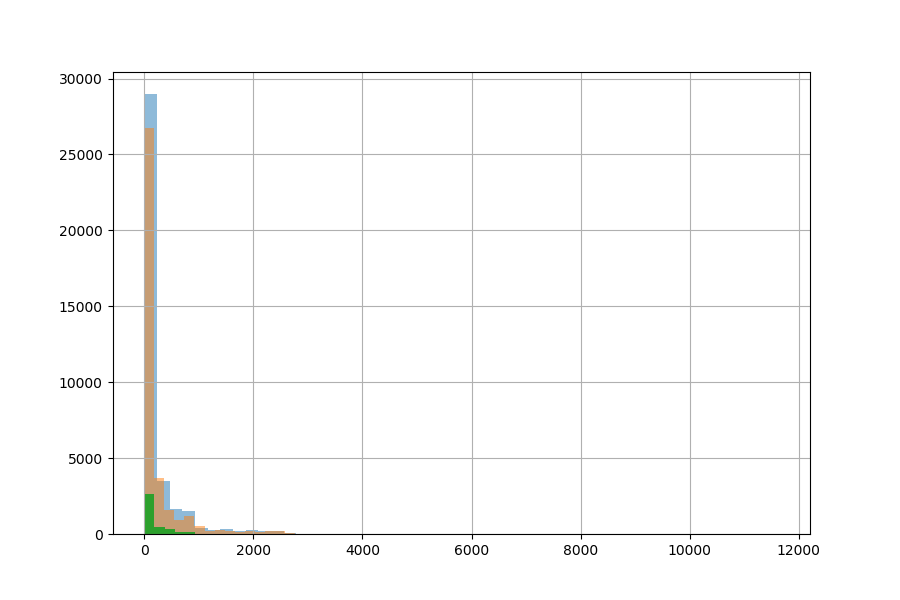

<IPython.core.display.Javascript object>


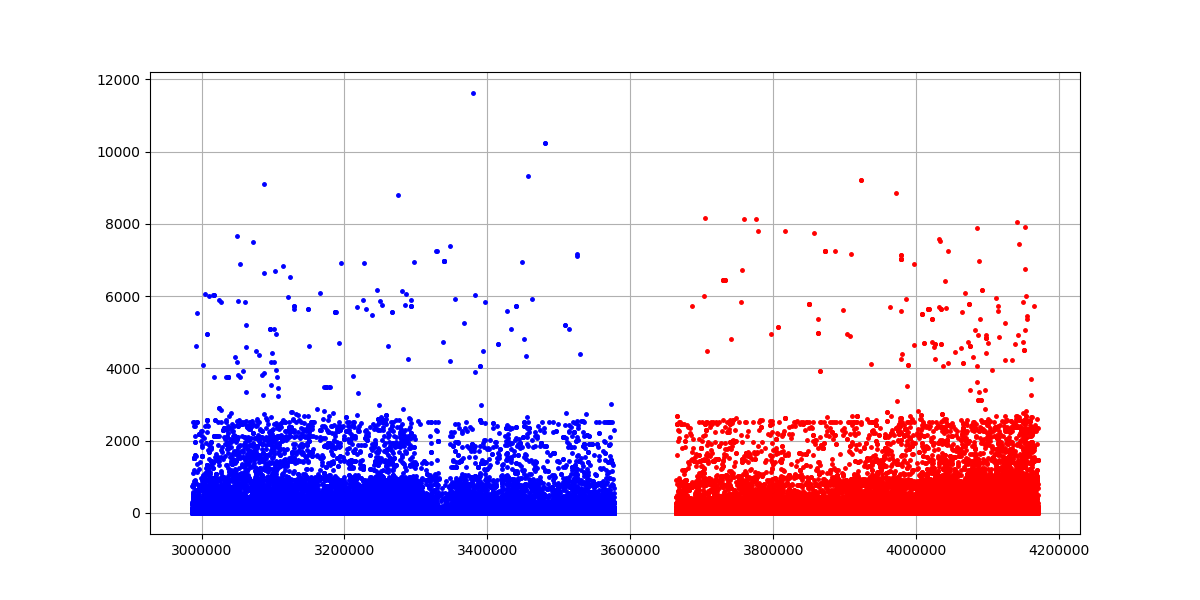

In [12]:
DEBUG = True
# %matplotlib inline
%matplotlib notebook

if DEBUG == True:
    plt.figure(figsize=(9,6))
    col ='dist2'
    see_distribution(col,50)
    plt.figure(figsize=(12,6))
    plot_trend(col)

In [14]:
if DEBUG == True:
    text_distribution(col)

NameError: name 'train_transaction_transformed' is not defined

In [15]:
print(train_transaction.shape)
print(test_transaction.shape)

(590540, 393)
(506691, 392)


In [16]:
train_transaction.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,800657,13926,NaN,150.0,9524.0,142.0,267648.0,315.0,87.0,19.0,3000.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,480.0,13.0,480.0,700.0,480.0,480.0,800.0,480.0,13.0,13.0,480.0,480.0,480.0,0.0,1.0,1.0,1.0,122947.0,0.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,10.0,10.0,6.0,8.0,NaN,3.0,4.0,5.0,5.0,3.0,4.0,3.0,4.0,2.0,3.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,5.0,10.0,10.0,2.0,4.0,10.0,10.0,10.0,6.0,6.0,3.0,3.0,50.0,6.0,8.0,3.0,3.0,3.0,3.0,4.0,5.0,2000.0,2000.0,300.0,300.0,300.0,2000.0,2000.0,2000.0,2000.0,2000.0,10.0,12.0,12.0,3.0,2.0,3.0,8.0,12.0,50.0,50.0,50.0,10.0,5.0,10.0,10.0,6.0,5.0,6.0,25.0,5.0,5.0,10.0,5.0,6.0,6.0,3.0,3.0,5.0,3.0,3.0,5.0,5.0,5.0,2000.0,2000.0,2000.0,500.0,300.0,2000.0,200.0,500.0,500.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,30.0,30.0,30.0,10.0,30.0,30.0,3.0,10.0,5.0,5.0,5.0,10.0,25.0,10.0,15.0,15.0,15.0,15.0,5.0,6.0,6.0,5.0,5.0,2.0,2.0,6.0,6.0,6.0,6.0,6.0,3.0,5.0,4.0,3.0,3.0,5.0,6.0,6.0,5.0,5.0,10.0,10.0,10.0,4.0,6.0,6.0,2000.0,2000.0,2000.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,400.0,400.0,400.0,400.0,400.0,400.0,0.0,50.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [17]:
# selected_cols = [
#     'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V21', 'V22',
#     'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32',
#     'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42',
#     'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V61', 'V62',
#     'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72',
#     'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V8', 'V83',
#     'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93',
#     'V94', 'V98', 'V99', 'V100', 'V104', 'V108', 'V109', 'V110', 'V112',
#     'V113', 'V114', 'V115', 'V116', 'V123', 'V124', 'V125', 'V138', 'V139',
#     'V140', 'V141', 'V142', 'V146', 'V147', 'V148', 'V149', 'V153', 'V154', 'V155',
#     'V156', 'V157', 'V158', 'V161', 'V162', 'V163', 'V169', 'V172', 'V173', 'V174',
#     'V175', 'V184', 'V188', 'V189', 'V194', 'V195', 'V197', 'V198', 'V200'
# ]

In [19]:
selected_cols = []
for col in test_transaction.columns:
    if(abs(sc.stats.pearsonr(train_df[col],train_y)[0]) > 0.01):
        selected_cols.append(col)

NameError: name 'train_df' is not defined

In [ ]:
train_transaction = train_transaction[selected_cols]
test_transaction = test_transaction[selected_cols]

In [ ]:
print(train_transaction.shape)
print(train_y.shape)
print(test_transaction.shape)

In [ ]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=False, random_state=42)

lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**16,
                    'max_depth':16,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':1,
                    'n_estimators':5000,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': 42,
                    'early_stopping_rounds':100, 
                } 

# train_y = train_transaction['isFraud'].copy()
# train_transaction = train_transaction.drop(['isFraud'],axis=1)

oof = np.zeros(len(train_transaction))
prediction = np.zeros(len(test_transaction))
scores = []
feature_importance = pd.DataFrame()
for fold_n, (train_index, valid_index) in enumerate(folds.split(train_transaction)):
    print('Fold', fold_n, 'started at', time.ctime())

    X_train, X_valid = train_transaction.iloc[train_index], train_transaction.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]

    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(train_transaction, train_y, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
            verbose=1000, early_stopping_rounds=200)

    y_pred_valid = model.predict(X_valid)
    y_pred = model.predict(test_transaction, num_iteration=model.best_iteration_)

    oof[valid_index] = y_pred_valid.reshape(-1,)
    scores.append(mean_absolute_error(y_valid, y_pred_valid))

    prediction += y_pred 

    fold_importance = pd.DataFrame()
    fold_importance["feature"] = train_transaction.columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

prediction /= n_fold
print(' CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
print('----------------------------------------')
feature_importance["importance"] /= n_fold

sub = pd.read_csv('../input/sample_submission.csv')
sub['isFraud']=prediction
sub.head()


In [ ]:
# sub.to_csv('../submissions/using-only-v.csv', index=False)